## Overview

This notebook explores the use of the regime shift detection algorithm presented by [Rodionov (2004)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004GL019448), and which was previously used by [Penderson et al. (2013)](https://journals.ametsoc.org/view/journals/clim/26/4/jcli-d-11-00723.1.xml?tab_body=fulltext-display) in the Delware River Basin. 

The study by Penderson et al. (2013) claimed that a strong pluvial (wet) regime dominated the upper DRB from 1970-2011 (time of study).  This notebook attempts to replicate the analysis and extend it the present, using the Historic Reconstruction data. 

See a write up of the analysis here: https://waterprogramming.wordpress.com/2023/07/07/rodionovs-regime-shift-detection-algorithm-and-the-epic-pluvial-the-delaware-basin/

: 

In [458]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns

# Directory to pywrdrb project
pywrdrb_directory = '../../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [459]:
def remove_seasonality(df):
    # Extract the month and day from the datetime index
    df['month'] = df.index.month
    df['day'] = df.index.day

    # Group the data by month and day and calculate the average streamflow for each combination
    monthly_average = df.groupby(['month', 'day']).mean()

    # Merge the monthly average data back to the original dataframe based on month and day
    merged_df = pd.merge(df, monthly_average, on=['month', 'day'], how='left', suffixes=('', '_avg'))

    # Calculate the deseasonalized streamflow by subtracting the average streamflow for each day
    df_deseasonalized = merged_df.drop(['month', 'day'], axis=1)
    df_deseasonalized = df_deseasonalized.subtract(df_deseasonalized.filter(regex='_avg$').values)

    # Remove the temporary columns
    df_deseasonalized = df_deseasonalized.drop(df_deseasonalized.filter(regex='_avg$').columns, axis=1)
    df_deseasonalized.index = pd.to_datetime(df.index)
    return df_deseasonalized


In [460]:
Q = pd.read_csv('../outputs/historic_reconstruction_daily_nhmv10_mgd.csv',
                sep = ',', index_col=0, parse_dates=True)

full_Q = pd.read_csv('../data/historic_unmanaged_streamflow_1900_2022_cms.csv', sep=',',parse_dates=True, index_col=0)
full_Q.index = pd.to_datetime(full_Q.index.date)

Q_nodes = pd.DataFrame(index= Q.index,
                       columns= list(obs_pub_site_matches.keys()))

for node, sites in obs_pub_site_matches.items():
    if sites:
        Q_nodes[node] = Q.loc[:, sites].sum(axis=1)
    else:
        Q_nodes[node] = Q[node]
Q_nodes['Total NYC'] = Q_nodes.loc[:,['cannonsville', 'pepacton', 'neversink']].sum(axis=1)


<Axes: >

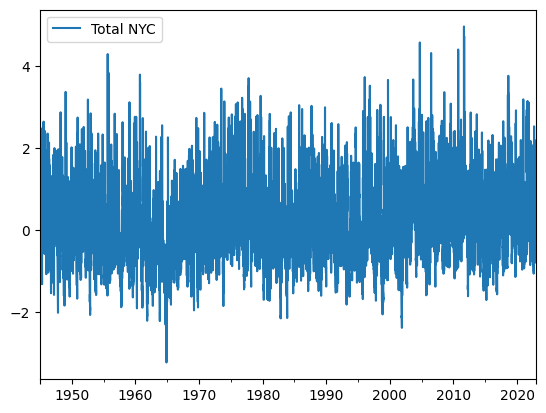

In [451]:

test_flow = np.log(Q_nodes.loc[:, ['Total NYC']])
test_flow = np.log(full_Q.iloc[:,[full_Q.isna().sum().argmin()]].dropna())
# test_flow.index = pd.to_datetime(test_flow.index.date)

deseasoned_Q = remove_seasonality(test_flow)
deseasoned_Q.head(1)
deseasoned_Q.plot()

annual_sum_Z = deseasoned_Q.groupby(deseasoned_Q.index.year).sum()
annual_mean_Z = deseasoned_Q.groupby(deseasoned_Q.index.year).mean()

# sns.kdeplot(annual_mean_Z)
annual_mean_Z.plot()

In [453]:
def rodionov_algorithm(streamflow_data, l, p):
    # Step 1: Set the cut-off length l of the regimes
    # l: Number of years for each regime
    # p: Probability level for significance
    N = len(streamflow_data)

    # Step 2: Determine the difference diff for statistically significant mean values
    t_stat = np.abs(t.ppf(p, (2*l-2)))
    avg_var = np.mean([np.var(streamflow_data[i:(i+l)]) for i in range(N-l)])
    diff = t_stat * np.sqrt(2 * avg_var / l)

    n = len(streamflow_data)
    regime_shift_indices = []
    rsi_values = []

    # Step 3: Calculate initial mean for regime R1
    r1 = np.mean(streamflow_data[:l])
    r2_lower_bound = r1 - diff
    r2_upper_bound = r1 + diff

    # Keep track of regime means
    N_regimes = 1
    r_means = [r1]

    # Keep track of RSI at every step
    rsi = np.zeros(n)

    i = l + 1
    while i < n:
        
        # Step 4: Check if the value exceeds the range of R1 ± diff
        if streamflow_data[i] < r2_lower_bound or streamflow_data[i] > r2_upper_bound:
            j = i

            # Estimate the mean of regime 2 as the upper bound of r1 distribution
            test_r2 = r2_lower_bound if streamflow_data[i] < r2_lower_bound else r2_upper_bound
            
            # Step 5: Calculate regime shift index (RSI) across next l-window
            for k in range(j + 1, min(j + l,n)):
                if streamflow_data[j] > r1:
                    rsi[j] += (streamflow_data[k] - test_r2)/(avg_var*l)
                elif streamflow_data[j] < r1:
                    rsi[j] += (test_r2 - streamflow_data[k])/(avg_var*l)

                # Step 6: Test for a regime shift at year j
                if rsi[j] < 0:
                    rsi[j] = 0
                    break

            # Step 7: Confirm significant regime shift at year j
            if rsi[j] > 0:
                regime_shift_indices.append(j)
                r2 = np.mean(streamflow_data[j:min(j+l,n)])
                r1 = r2
                r2_lower_bound = r1 - diff
                r2_upper_bound = r1 + diff
                rsi_values.extend(rsi[j + 1:j + l])

            i = j + 1
        else:
            # Recalculate average for R1 to include the new value
            r1 = ((l - 1) * r1 + streamflow_data[i]) / l
            r_means[-1] = r1

        i += 1

    return regime_shift_indices, rsi

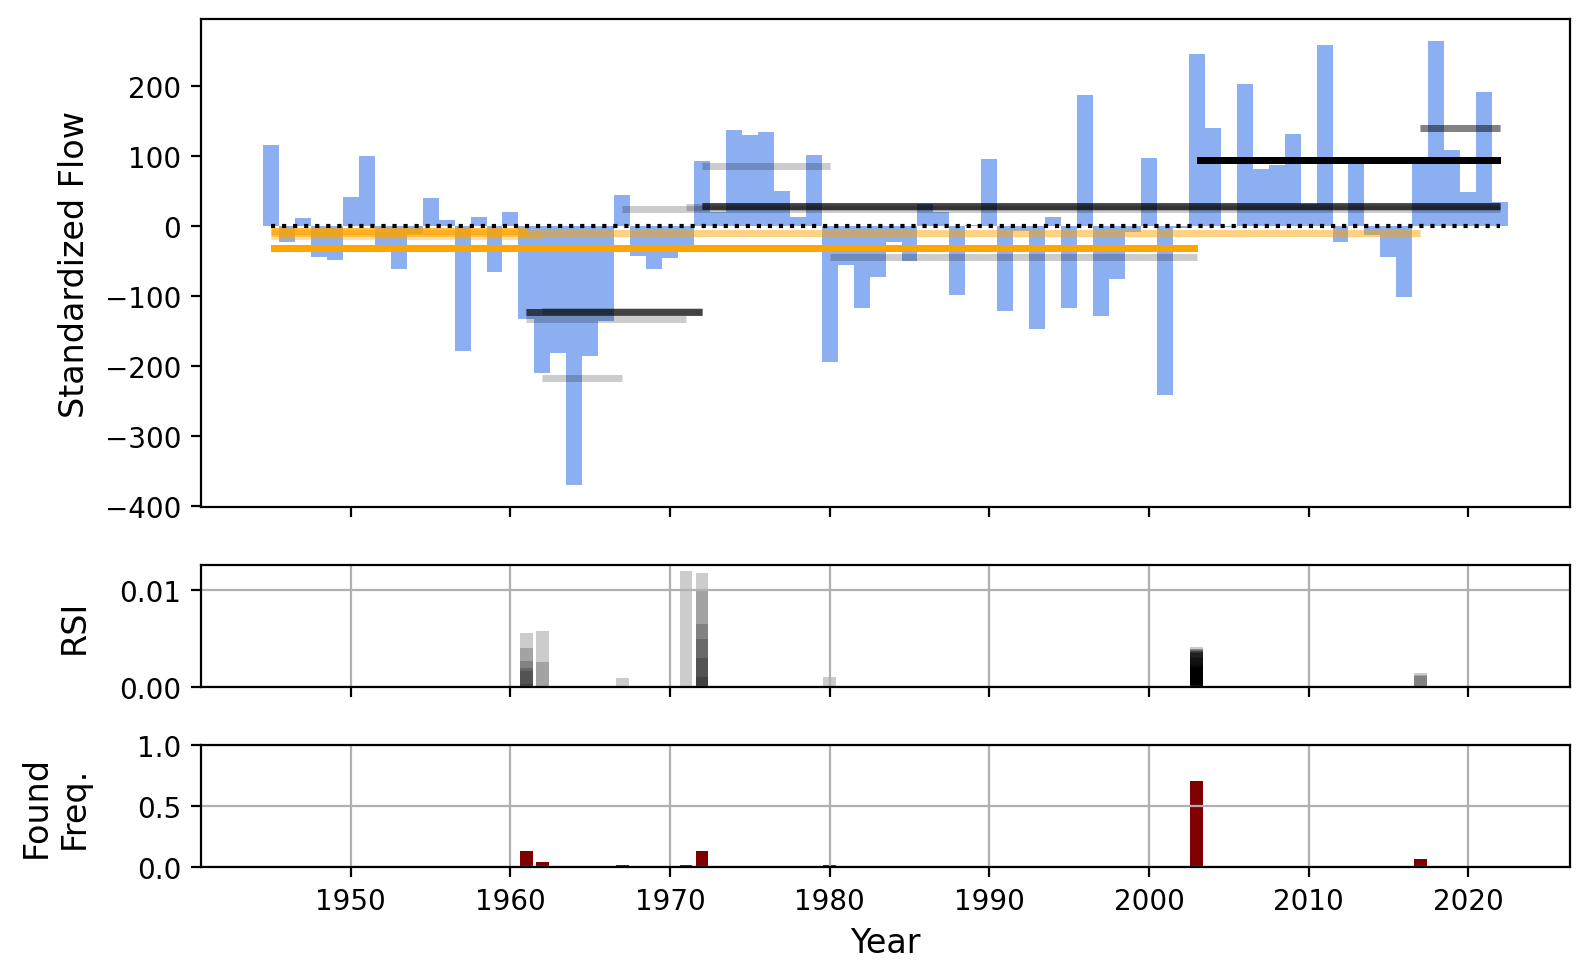

In [466]:
Z = annual_mean_Z


### PLOTTING ###
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8,5), dpi=200, 
                               sharex=True, gridspec_kw={'height_ratios':[1,0.25,0.25]})

cmap = mpl.colormaps['cool']
norm = mcolors.Normalize(vmin=-1, vmax=1)

# Plot standardized Z values
ax1.bar(Z.index, Z.values.flatten(), np.ones(len(Z)), label ='Standardized Flow', 
        color = 'cornflowerblue', alpha=0.75)
# ax1.plot(Z.index, Z.values.flatten(), label ='Standardized Flow', 
#          color = 'cornflowerblue', alpha =0.75)

# Add total mean
ax1.hlines(np.mean(Z.values), xmin=Z.index[0], xmax=Z.index[-1], 
           color = 'black', ls = ':', label=f'Total Mean: {np.mean(Z.values):.{3}f}')

shift_counter = np.zeros(len(Z))
test_lengths= np.arange(5,50,1)
for l_length in test_lengths:
    shift_indices, rsi_values = rodionov_algorithm(Z.values.flatten(),
                                                    l_length, p = 0.01)
    
    if shift_indices:
        # Add initial regime mean
        r_mean = np.mean(Z.values[0:shift_indices[0]])
        ax1.hlines(r_mean, xmin=Z.index[0], xmax=Z.index[shift_indices[0]], 
                   color = 'orange', label=f'R1 Mean {r_mean:.{3}f}', lw=2.5, alpha = 0.2)

        for i in range(len(shift_indices)):

            r_start = shift_indices[i]
            shift_counter[r_start] += 1
            if r_start == shift_indices[-1]:
                r_end = -1
            else:
                r_end = shift_indices[i+1]
            
            r_mean = np.mean(Z.values[r_start:r_end])
            ax1.hlines(r_mean, xmin=Z.index[r_start], xmax=Z.index[r_end], 
                    color = 'black', #cmap(norm(r_mean)), 
                    label=f'R{i+1} Mean {r_mean:.{3}f}', 
                    linewidth=2.5, alpha = 0.2)

    # Plot RSI values
    ax2.grid(which='major')
    ax2.bar(Z.index, rsi_values, alpha = 0.2, color='black')
    ax2.set_ylabel('RSI', fontsize=12)
    ax2.yaxis.set_label_coords(-0.08, 0.5)
    
    
    # Plot Shift counts
    ax3.grid(which='major')
    ax3.bar(Z.index, shift_counter/len(test_lengths), color='maroon')
    ax3.set_ylabel('Found\nFreq.', fontsize=12)
    ax3.yaxis.set_label_coords(-0.08, 0.5)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylim([0,1.0])
    

ax1.set_ylabel('Standardized Flow', fontsize=12)
ax1.yaxis.set_label_coords(-0.08, 0.5)

# h, l = ax1.get_legend_handles_labels()
# legend= ax2.legend(h,l,loc='lower center', bbox_to_anchor=(0.5, -2), ncol=2)
plt.tight_layout()
plt.show()

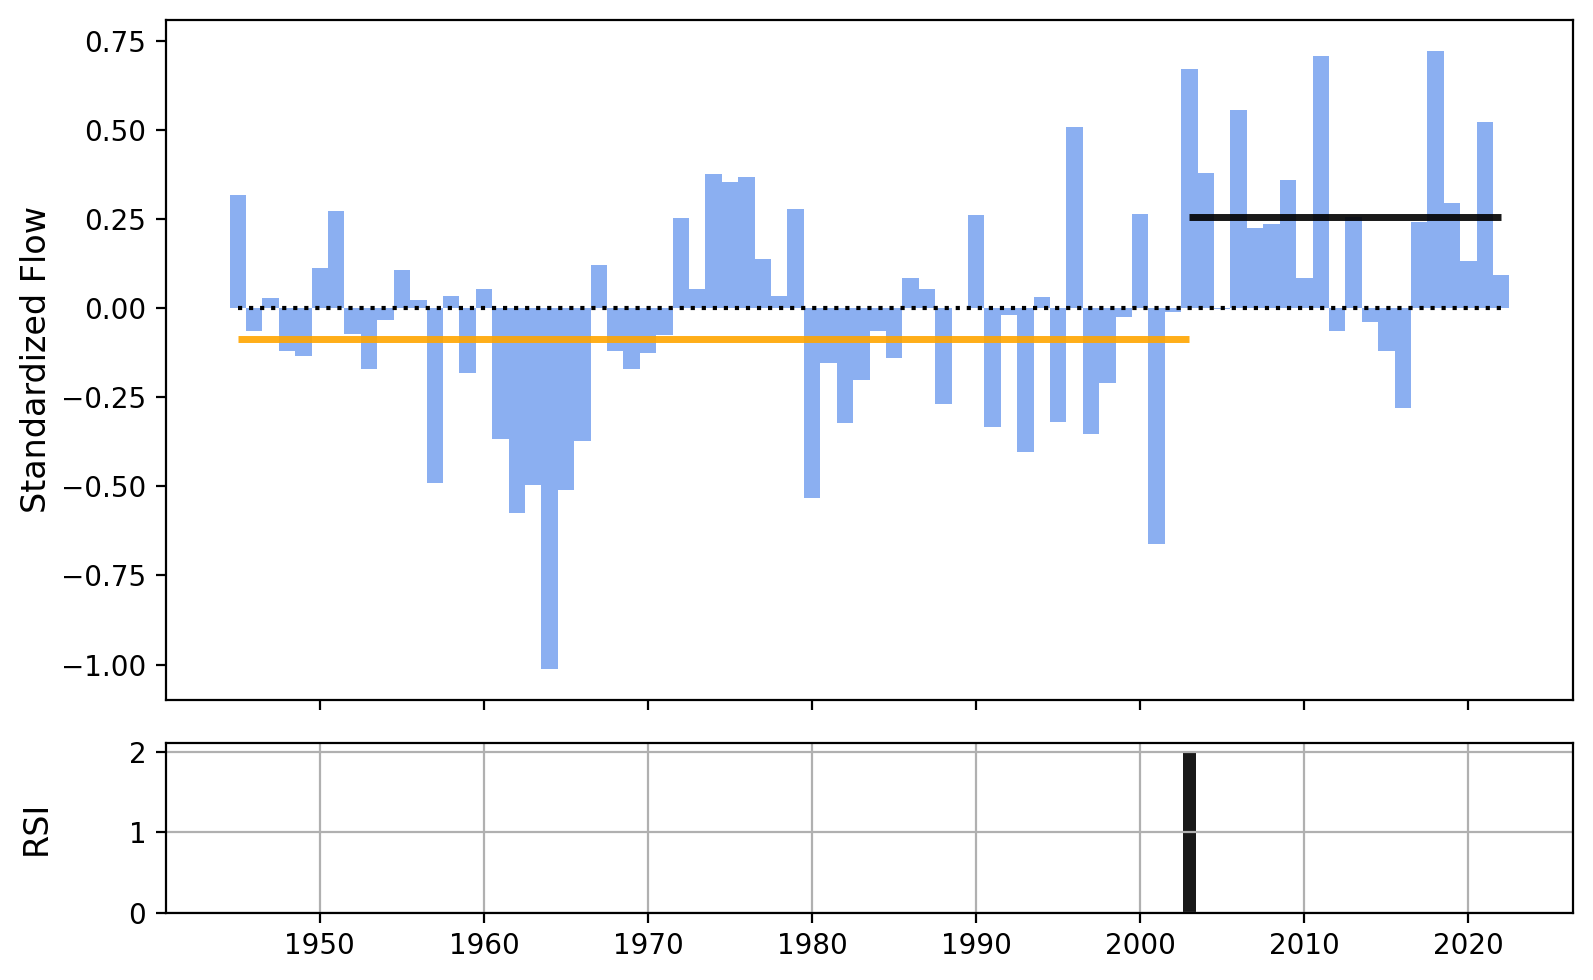

In [457]:
Z = annual_mean_Z


### PLOTTING ###
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,5), dpi=200, 
                               sharex=True, gridspec_kw={'height_ratios':[1,0.25]})

cmap = mpl.colormaps['cool']
norm = mcolors.Normalize(vmin=-1, vmax=1)

# Plot standardized Z values
ax1.bar(Z.index, Z.values.flatten(), np.ones(len(Z)), label ='Standardized Flow', 
        color = 'cornflowerblue', alpha=0.75)
# ax1.plot(Z.index, Z.values.flatten(), label ='Standardized Flow', 
#          color = 'cornflowerblue', alpha =0.75)

# Add total mean
ax1.hlines(np.mean(Z.values), xmin=Z.index[0], xmax=Z.index[-1], 
           color = 'black', ls = ':', label=f'Total Mean: {np.mean(Z.values):.{3}f}')

shift_indices, rsi_values = rodionov_algorithm(Z.values.flatten(),
                                                20, p = 0.05)

if shift_indices:
    # Add initial regime mean
    r_mean = np.mean(Z.values[0:shift_indices[0]])
    ax1.hlines(r_mean, xmin=Z.index[0], xmax=Z.index[shift_indices[0]], 
                color = 'orange', label=f'R1 Mean {r_mean:.{3}f}', lw=2.5, alpha = 0.9)

    for i in range(len(shift_indices)):

        r_start = shift_indices[i]
        shift_counter[r_start] += 1
        if r_start == shift_indices[-1]:
            r_end = -1
        else:
            r_end = shift_indices[i+1]
        
        r_mean = np.mean(Z.values[r_start:r_end])
        ax1.hlines(r_mean, xmin=Z.index[r_start], xmax=Z.index[r_end], 
                color = 'black', #cmap(norm(r_mean)), 
                label=f'R{i+1} Mean {r_mean:.{3}f}', 
                linewidth=2.5, alpha = 0.9)

# Plot RSI values
ax2.grid(which='major')
ax2.bar(Z.index, rsi_values, alpha = 0.9, color='black')
ax2.set_ylabel('RSI', fontsize=12)
ax2.yaxis.set_label_coords(-0.08, 0.5)


ax1.set_ylabel('Standardized Flow', fontsize=12)
ax1.yaxis.set_label_coords(-0.08, 0.5)

# h, l = ax1.get_legend_handles_labels()
# legend= ax2.legend(h,l,loc='lower center', bbox_to_anchor=(0.5, -2), ncol=2)
plt.tight_layout()
plt.show()